# Demonstration of Instability in the Initial Calibration Algorithm

### In this notebook, we demonstrate the challenges encountered when testing the first version of our adaptive calibration algorithm. Specifically, we show how early miscalibration leads to runaway behavior in the uncertainty parameters `q_t` and `Q_t`, resulting in overly conservative intervals and unstable predictions.


In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations, params
from models.linear_model import LinearModel_Estimator
from calibrator_module.BCUC_calibrator import BCUC_Calibrator
from models.model_utils import params


In [9]:

!python observation_generation.py --person_name "q_Q_explosion/first_person" --format npz --initial_Q 0.0001


Creating linear system...

Generating observations for random_zeros_and_actions actions...
Generated 201 observations
Observation shape: (1,)
Data saved as observations/q_Q_explosion/first_person/observations_random_zeros_and_actions_for_Q0.0001_initialModel_0.0001.npz
Model parameters saved as observations/q_Q_explosion/first_person/observations_random_zeros_and_actions_for_Q0.0001_initialModel_0.0001_params.json
Observation mean: [7.50733814]
Observation std: [1.60634976]
Observation generation complete!

Recommended workflow:
1. Use .npz format for numerical analysis in Python
2. Use .csv format for analysis in Excel or pandas
3. Use .json format for human-readable debugging
4. Use .mat format for MATLAB interoperability


In [50]:
#load 
data = np.load("observations/q_Q_explosion/first_person/observations_random_zeros_and_actions_for_Q0.0001_initialModel_0.0001.npz")
masked_observations = mask_observations(data['observations'])
actions = data['actions']

patient_1_model = LinearModel_Estimator(**params) #Q_initial = 0.1
print(f"Initial Q matrix: {patient_1_model.Q}")
print(f"wanted Q matrix: 0")
calibrator = BCUC_Calibrator(patient_1_model)  # Note: Capital 'C' in Calibrator
patient_1_calibrated = calibrator.calibrate_model(masked_observations, actions)
boolFlag = patient_1_model is patient_1_calibrated

print(f"calibrated Q :{patient_1_calibrated.Q}")

Initial Q matrix: [[0.0001]]
wanted Q matrix: 0
e_t:1, mean_error = 1.0
Computed eta: 0.12985954886347129, eta_max: 0.5
Max score: 1.2985954886347129
mean: 1.0
Updated Q : [[0.00012329]], q: 1.1103806165339507
e_t:0, mean_error = 0.5
Computed eta: 0.12985954886347129, eta_max: 0.5
Max score: 1.2985954886347129
mean: 0.5
Updated Q : [[0.00016471]], q: 1.1558314586361655
e_t:0, mean_error = 0.3333333333333333
Computed eta: 0.12985954886347129, eta_max: 0.5
Max score: 1.2985954886347129
mean: 0.3333333333333333
Updated Q : [[0.00022921]], q: 1.1796390425944687
e_t:1, mean_error = 0.5
Computed eta: 0.5, eta_max: 0.5
Max score: 5.604616309397939
mean: 0.5
Updated Q : [[0.00042061]], q: 1.3546390425944688
e_t:0, mean_error = 0.4
Computed eta: 0.5, eta_max: 0.5
Max score: 5.604616309397939
mean: 0.4
Updated Q : [[0.00092085]], q: 1.4796390425944688
e_t:1, mean_error = 0.5
Computed eta: 0.5, eta_max: 0.5
Max score: 5.604616309397939
mean: 0.5
Updated Q : [[0.00252114]], q: 1.6546390425944688
e

In [53]:
Q_vals = calibrator.Q_history
q_vals = calibrator.q_history
interval_widths = calibrator.interval_widths
E = calibrator.conformal_p_control.E
interval_widths_with_correction = [val*q for val, q in zip(interval_widths, q_vals)]
meu = [dictionary['mean'].flatten() for dictionary in patient_1_calibrated.dist_estimates]
std = [np.sqrt(dictionary['var'].flatten()) for dictionary in patient_1_calibrated.dist_estimates]

In [60]:
meu = np.array(meu).squeeze()   # or use .flatten()
std = np.array(std).squeeze()

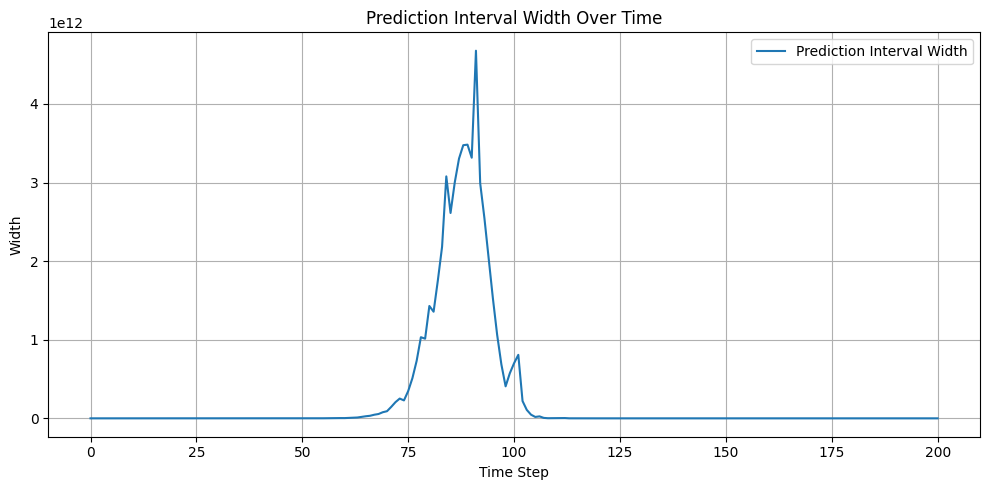

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(interval_widths_with_correction, label="Prediction Interval Width")
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.title("Prediction Interval Width Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plot_interval_width.png", dpi=300)
plt.show()

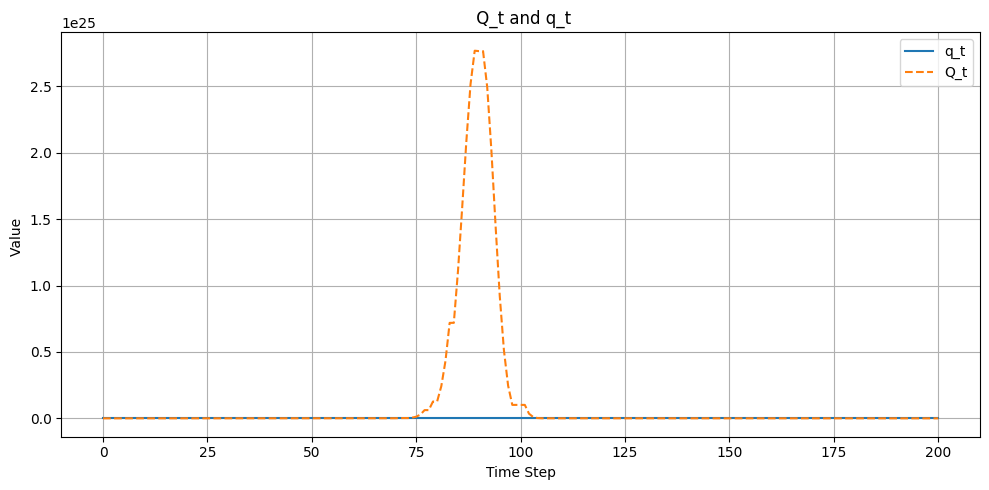

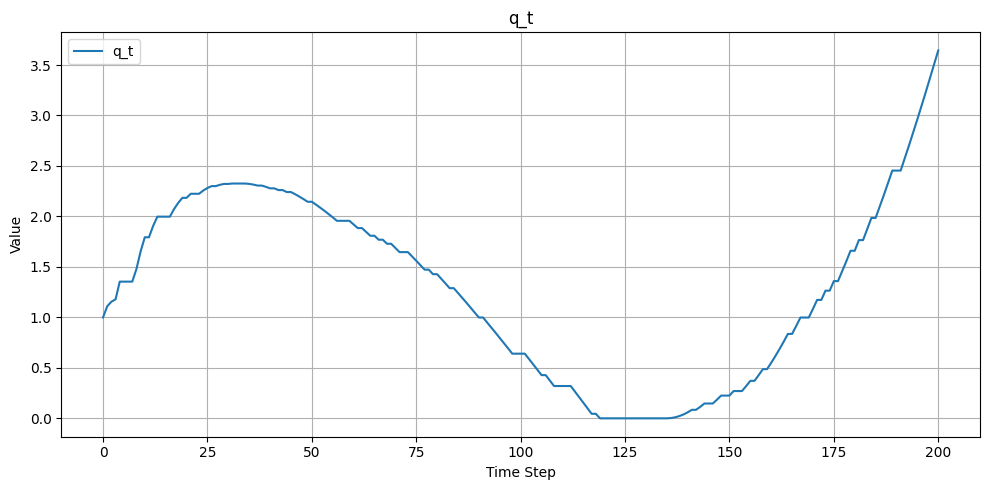

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(q_vals, label="q_t")
plt.plot(Q_vals, label="Q_t", linestyle="--")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value ")
plt.title(" Q_t and q_t")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_q_Q_over_time.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(q_vals, label="q_t")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("q_t")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_q_over_time.png", dpi=300)
plt.show()

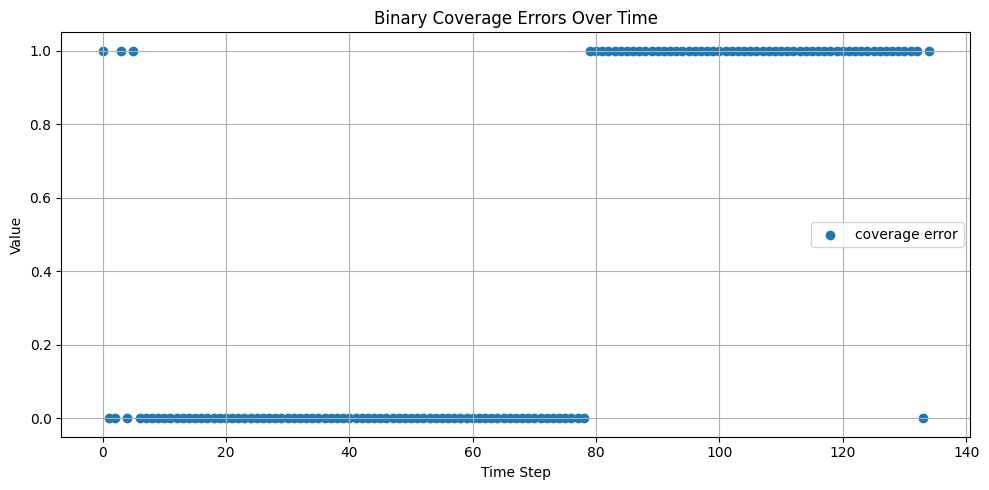

In [ ]:
plt.figure(figsize=(10, 5))
time_steps = range(len(E))  # or your actual time step data
plt.scatter(time_steps, E, label="coverage error")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Binary Coverage Errors Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_E_over_time.png", dpi=300)
plt.show()

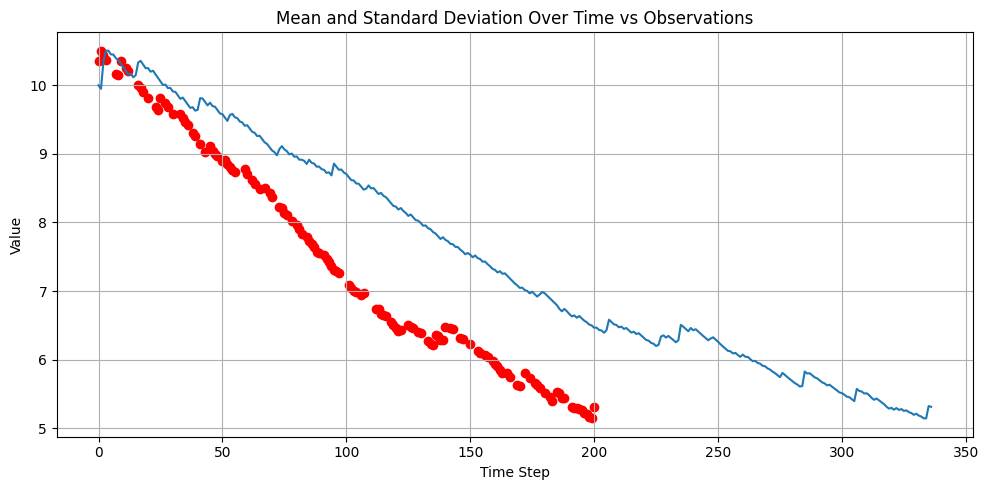

In [82]:
plt.figure(figsize=(10, 5))
ts = np.arange(len(meu)) 
plt.plot(ts, meu, label=" meu")
# plt.fill_between(ts, meu- std, meu + std, alpha=0.2, label="Confidence Interval")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation Over Time vs Observations")
plt.grid(True)
plt.tight_layout()
plt.savefig("calibrated_distribution_over_time_vs_observation.png", dpi=300)

ts_new = np.arange(np.size(masked_observations))
mask = ~np.isnan(masked_observations)
ts_valid = ts_new[mask.flatten()]
obs_valid = masked_observations[mask.flatten()]
plt.scatter(ts_valid, obs_valid, color='red', label='Observations')
plt.show()


In [80]:
ts_new

array([0])

In [71]:
np.arange(np.size(masked_observations))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18